# Strategy based on RSI indicator.
1. Buy the instrument such as Nifty or SPY when the RSI is more than 50
2. Exit conditions:
 a. Take profit of 5% or RSI > 75
 b. Stop loss of - 2%

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import talib 
import pyfolio as pf
import datetime as dt
warnings.filterwarnings('ignore')

C:\Users\ACER\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
from get_data import get_data

In [11]:
def testing_rsi(df,tp,sl):
    
    #initializing the new columns 
    df['rsi']= talib.RSI(df['close'])
    df['take_profit']= 0
    df['stop_loss']= 0
    df['signal']= 0
    df['trade_price']=0
    
    n= df.shape[0] # defining the leangth for the loop
    
    for i in range(1,n):
        
        if df.signal.iloc[i-1]==0: #if we do not hold any previous position in the asset, following code will execute
            
            if df.rsi[i]> 50 :
                df.signal.iloc[i]= 1 # initiating trade thus setting signal to 1
                df.trade_price.iloc[i]= df.close.iloc[i] # assuming we'll buy the stock at the close price
                df.take_profit.iloc[i]= df.trade_price.iloc[i] * (1+tp) #setting take profit target
                df.stop_loss.iloc[i]= df.trade_price.iloc[i] * (1+sl) #setting stop loss target
            else:
                df.trade_price.iloc[i]= df.trade_price.iloc[i-1] #if previous position is not zero, then we'll continue the trade price
                
        if df.signal.iloc[i-1] == 1:  # if we are holding a position in the asset, following code will execute
            
            if df.low.iloc[i]<= df.stop_loss.iloc[i-1]:  #checking if we hit the stop loss, then folling code will execute
                df.trade_price.iloc[i]= df.stop_loss.iloc[i] # we'll square off the position at SL thus trade price will become stop loss price
                df.take_profit.iloc[i]= 0  # We squared off the position and next signal hasn't been generated thus TP, SL and signal will be zero
                df.stop_loss.iloc[i]=0
                df.signal.iloc[i]=0
                
            elif df.high.iloc[i]>= df.take_profit.iloc[i-1]: #checking if we hit the TP, following code will execute
                df.trade_price.iloc[i]= df.take_profit.iloc[i-1] # we'll square off the position at TP price thus that will become the trade price
                df.take_profit.iloc[i]=0 # We squared off the position and next signal hasn't been generated thus TP, SL and signal will be zero
                df.stop_loss.iloc[i]=0
                df.signal.iloc[i]=0
                
            elif df.rsi.iloc[i]>=75: #checking if we hit the rsi target, following code will execute
                df.trade_price.iloc[i]= df.close.iloc[i] # assuming we'll square off at close price, that will become the trade price
                df.signal.iloc[i]=0 # We squared off the position and next signal hasn't been generated thus TP, SL and signal will be zero
                df.take_profit.iloc[i]=0
                df.stop_loss.iloc[i]=0
                
            else:  # Since we hold a position and nothing is hit, we'll carry the previously generated signals and targets forward
                df.trade_price.iloc[i]= df.trade_price.iloc[i-1]
                df.signal.iloc[i]= df.signal.iloc[i-1]
                df.stop_loss.iloc[i]=df.stop_loss.iloc[i-1]
                df.take_profit.iloc[i]= df.take_profit.iloc[i-1]
    
    df['bnh_returns']= np.log(df.close/df.close.shift(1))
    df['strategy_returns']= df.signal*df.bnh_returns
    
    print('The strategy returns are: ', np.round(df.strategy_returns.cumsum()[-1],2))
    
    df[['bnh_returns', 'strategy_returns']].cumsum().plot(figsize=(18,9), grid=True)
    plt.title('RSI Strategy VS Buy and Hold ')
    plt.xlabel('Years')
    plt.ylabel('Returns')
    plt.show()                  

In [12]:
df= get_data('GOOG','2019-1-1','2023-1-1')

[*********************100%***********************]  1 of 1 completed


The strategy returns are:  1.73


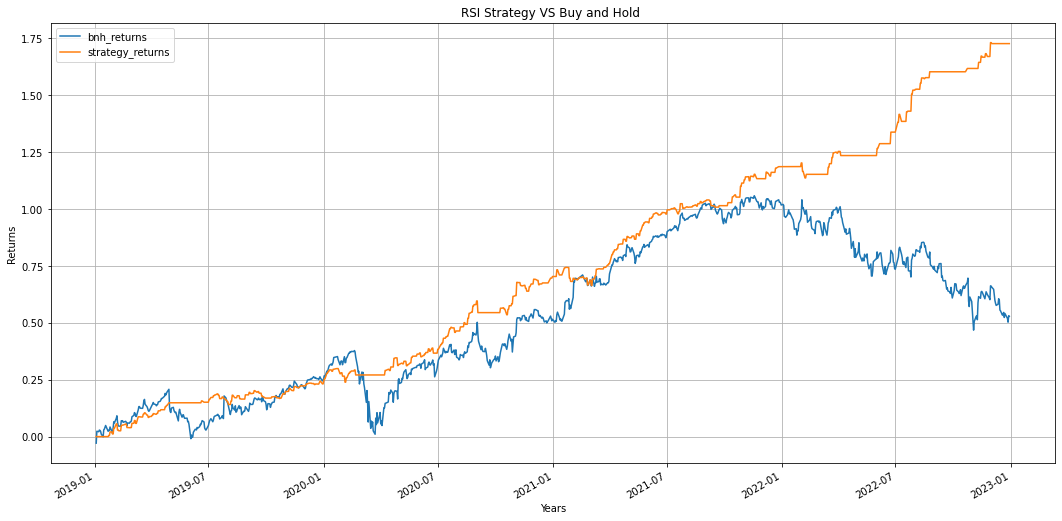

In [13]:
testing_rsi(df,tp= 0.04,sl= 0.04)

Start date,2019-01-02
End date,2022-12-30
Total months,48
,Backtest
Annual return,52.3%
Cumulative returns,437.5%
Annual volatility,14.9%
Sharpe ratio,2.90
Calmar ratio,6.64
Stability,0.97
Max drawdown,-7.9%


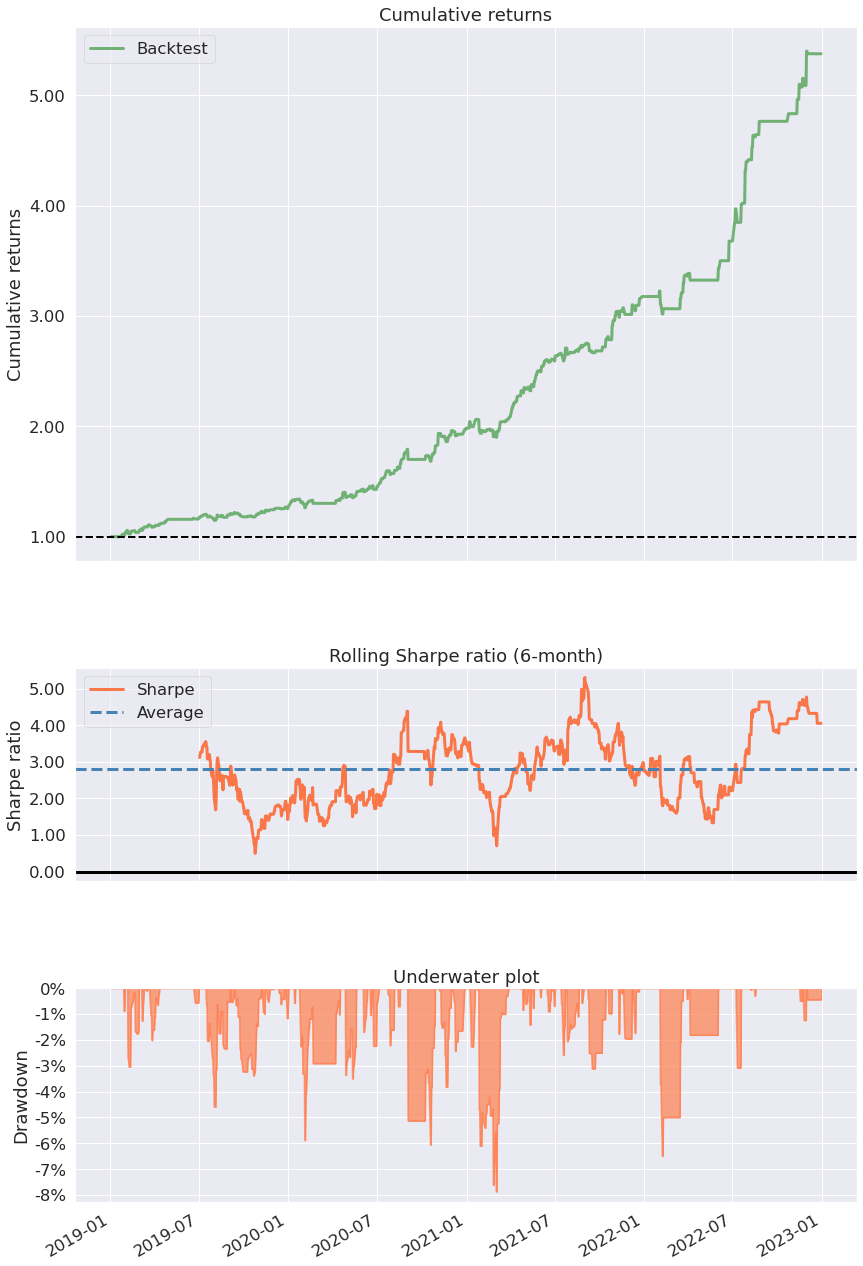

In [14]:
pf.create_simple_tear_sheet(df.strategy_returns)